Import Library

In [ ]:
# !pip install tensorflow

In [1]:
# Load, explore and plot data
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
%matplotlib inline
# Train test split
from sklearn.model_selection import train_test_split
# Text pre-processing
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
# Modeling
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Embedding, Dropout, GlobalAveragePooling1D, Flatten, SpatialDropout1D, Bidirectional

2024-09-02 21:16:39.061083: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-02 21:16:39.091816: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-02 21:16:39.099740: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-02 21:16:39.126744: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-02 21:16:41.355511: W tensorflow/compiler/tf2

Load Data

In [3]:
# Muat DataFrame (ganti dengan path data kamu)
# Misalnya, df adalah DataFrame dengan kolom 'teks' dan 'label'
# Membaca DataFrame dari file HDF5
# df_awal = pd.read_hdf('DatasetGabunganSakernasFinal.h5', key='dataset')
# df_awal = pd.read_csv("mobil_listrik.csv")
df_awal = pd.read_csv("HasilAugmentasi_MobilListrik.csv")
df_awal['sentimen'] = df_awal['sentimen'].astype('category')
df = df_awal

Deskripsi Data

In [5]:
df.groupby('sentimen').describe().T

/tmp/ipykernel_127117/3707267751.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('sentimen').describe().T


sentimen                    0            1            2
Unnamed: 0 count   869.000000   426.000000   504.000000
           mean    750.527043   764.415493   766.440476
           std     444.686016   443.464323   424.039737
           min       1.000000     8.000000     0.000000
           25%     362.000000   358.000000   406.750000
           50%     749.000000   782.000000   762.500000
           75%    1143.000000  1130.000000  1122.250000
           max    1516.000000  1515.000000  1514.000000

Visualisasi Data

In [4]:
# ham_msg_cloud = WordCloud(width =520, height =260, stopwords = STOPWORDS, max_font_size = 50, background_color = "black", colormap = 'Pastel1').generate(df)
# plt.figure(figsize=(16,10))
# plt.imshow(ham_msg_cloud, interpolation = 'bilinear')
# plt.axis('off') # turn off axis
# plt.show()

Distribusi Data

Text(0.5, 1.0, 'The distribution of ham and spam messages')

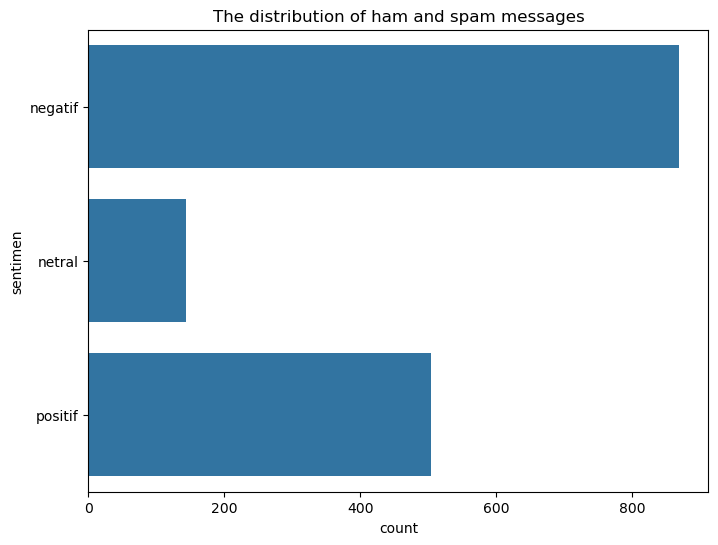

In [4]:
plt.figure(figsize=(8,6))
sns.countplot(df.sentimen)
plt.title('The distribution of ham and spam messages')

Tentukan panjang kata dari teks

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1517 entries, 0 to 1516
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   id_komentar    1517 non-null   object  
 1   nama_akun      1516 non-null   object  
 2   tanggal        1517 non-null   object  
 3   text_cleaning  1515 non-null   object  
 4   sentimen       1517 non-null   category
dtypes: category(1), object(4)
memory usage: 49.1+ KB


In [6]:
from sklearn.preprocessing import LabelEncoder
# Get length column for each text
df = df.dropna(subset=['teks'])
df['banyak_kata'] = df['teks'].apply(len)
df['msg_type'] = df['sentimen'].cat.codes
#df['msg_type'] = df['label'].map({'5221.0':0, '6111.0':1, '6112.0':2, '9211.0':3})

Data Splitting

In [7]:
x_train, x_test, y_train, y_test = train_test_split(df['teks'], df['msg_type'], stratify=df['msg_type'], test_size=0.2, random_state=43)

In [2]:
# Preprocessing: Text Vectorization and Label Encoding
trainset = pd.read_csv("HasilAugmentasi_Train.csv")
testset = pd.read_csv("Data_Test.csv")
x_train, y_train = trainset['teks'], trainset['sentimen']
x_test, y_test = testset['teks'], testset['sentimen']

Tokenisasi

In [3]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import re

# Definisikan parameter pra-pemrosesan
max_len = 272
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'
vocab_size = 3500

# def preprocess_text(text):
#     text = text.lower()
#     text = re.sub(r'\d+', '', text)  # Hapus angka
#     text = re.sub(r'[^\w\s]', '', text)  # Hapus tanda baca
#     text = text.strip()
#     text = re.sub(r'\s+', ' ', text)  # Hapus spasi ekstra
#     return text

# # Buat stemmer bahasa Indonesia
# factory = StemmerFactory()
# stemmer = factory.create_stemmer()

# # Pra-pemrosesan teks
# x_train = [preprocess_text(text) for text in x_train]
# x_train = [stemmer.stem(text) for text in x_train]

tokenizer = Tokenizer(num_words = vocab_size, 
                      char_level = False,
                      oov_token = oov_tok)
tokenizer.fit_on_texts(x_train)

# Get the word_index
word_index = tokenizer.word_index
total_words = len(word_index)
total_words

3833

Sequence dan Padding

In [4]:
#=============Proses untuk Data Training=================
training_sequences = tokenizer.texts_to_sequences(x_train)
training_padded = pad_sequences(training_sequences,
                                maxlen = max_len,
                                padding = padding_type,
                                truncating = trunc_type)
#=============Proses untuk Data Testing=================
testing_sequences = tokenizer.texts_to_sequences(x_test)
testing_padded = pad_sequences(testing_sequences,
                               maxlen = max_len,
                               padding = padding_type,
                               truncating = trunc_type)

print('Shape of training tensor: ', training_padded.shape)
print('Shape of testing tensor: ', testing_padded.shape)

Shape of training tensor:  (1530, 272)
Shape of testing tensor:  (304, 272)


Dense Model

/home/anugerahsurya/.local/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Compile Model

In [5]:
lr = 3e-5
num_epochs = 100
# Define parameter
vocab_size = 3500 
embedding_dim = 16
drop_value = 0.0
n_dense = 24

Latih Model

In [13]:

# Define Dense Model Architecture
model = Sequential()
model.add(Embedding(vocab_size,
                    embedding_dim,
                    input_length = max_len))
model.add(GlobalAveragePooling1D())
model.add(Dense(n_dense, activation='relu'))
model.add(Dropout(drop_value))
model.add(Dense(3, activation='softmax'))
model.summary()

from keras.optimizers import Adam
model.compile(loss = 'sparse_categorical_crossentropy', optimizer = Adam(learning_rate = lr) , metrics = ['accuracy'])

#early_stop = EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(training_padded,
                    y_train,
                    epochs=num_epochs, 
                    validation_data=(testing_padded, y_test),
                    verbose=1)

Epoch 1/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step - accuracy: 0.9236 - loss: 0.2657 - val_accuracy: 0.5822 - val_loss: 1.2931
Epoch 2/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9548 - loss: 0.2445 - val_accuracy: 0.5822 - val_loss: 1.2634
Epoch 3/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9493 - loss: 0.2416 - val_accuracy: 0.6020 - val_loss: 1.1989
Epoch 4/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9418 - loss: 0.2569 - val_accuracy: 0.5954 - val_loss: 1.2356
Epoch 5/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9369 - loss: 0.2558 - val_accuracy: 0.5888 - val_loss: 1.2472
Epoch 6/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9425 - loss: 0.2569 - val_accuracy: 0.5921 - val_loss: 1.2448
Epoch 7/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9547 - loss: 0.2436 - val_accuracy: 0.5888 - val_loss: 1.2514
Epoch 8/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9413 - loss: 0.2599 - val_accuracy: 0.5921 -

Evaluasi Model

In [14]:
model.evaluate(testing_padded, y_test)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6209 - loss: 1.1969 


[1.2613869905471802, 0.5986841917037964]

Bi-LSTM

In [7]:
from kerastuner.tuners import Hyperband
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, Dropout, Dense
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

def build_model(hp):
    model = Sequential()
    model.add(Embedding(vocab_size,
                        hp.Int('embedding_dim', min_value=128, max_value=512, step=64),
                        input_length=max_len))
    model.add(Bidirectional(LSTM(hp.Int('n_lstm', min_value=64, max_value=320, step=64),
                                 return_sequences=True)))
    model.add(Dropout(hp.Float('drop_lstm', min_value=0.2, max_value=0.7, step=0.1)))

    model.add(Bidirectional(LSTM(hp.Int('n_lstm', min_value=64, max_value=320, step=64),
                                 return_sequences=False)))
    model.add(Dropout(hp.Float('drop_lstm', min_value=0.2, max_value=0.7, step=0.1)))

    model.add(Dense(3, activation='softmax'))

    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
                  metrics=['accuracy'])

    return model

tuner = Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=30,
    factor=3,
    directory='my_dir',
    project_name='lstm_tuning'
)

early_stop = EarlyStopping(monitor='val_loss', patience=2)

tuner.search(training_padded, y_train,
             epochs=20,
             validation_data=(testing_padded, y_test),
             callbacks=[early_stop],
             verbose=1)

from sklearn.metrics import classification_report

# Dapatkan model terbaik dari tuning
best_model = tuner.get_best_models(num_models=1)[0]

# Prediksi pada data uji
y_pred = best_model.predict(testing_padded)
y_pred_classes = y_pred.argmax(axis=1)

# Tampilkan classification report
report = classification_report(y_test, y_pred_classes, target_names=['Negatif', 'Netral', 'Positif'], digits=4)
print("Classification Report:\n", report)

Trial 90 Complete [00h 02m 58s]
val_accuracy: 0.6282894611358643

Best val_accuracy So Far: 0.7269737124443054
Total elapsed time: 01h 47m 46s
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step


Melatih Model

In [22]:
from sklearn.metrics import classification_report
# Evaluate the model on the test data
y_pred = np.argmax(model2.predict(testing_padded), axis=-1)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Negatif', 'Netral', 'Positif']))

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step

Classification Report:
              precision    recall  f1-score   support

     Negatif       0.78      0.80      0.79        88
      Netral       0.07      0.09      0.08        11
     Positif       0.77      0.68      0.72        53

    accuracy                           0.70       152
   macro avg       0.54      0.52      0.53       152
weighted avg       0.72      0.70      0.71       152



GRU

In [33]:
# Define LSTM Model 
model3 = Sequential()
model3.add(Embedding(vocab_size, embedding_dim, input_length=max_len))
model3.add(SpatialDropout1D(drop_lstm))
model3.add(GRU(n_lstm, return_sequences=False))
model3.add(Dropout(drop_lstm))
model3.add(Dense(3, activation='softmax'))
model3.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_1             │ ?                      │   0 (unbuilt) │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [34]:
model3.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_1             │ ?                      │   0 (unbuilt) │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [35]:
model3.compile(loss = 'sparse_categorical_crossentropy',
                       optimizer = Adam(learning_rate = lr),
                       metrics=['accuracy'])

In [36]:
early_stop = EarlyStopping(monitor='val_loss', patience=2)
history = model3.fit(training_padded,
                     y_train,
                     epochs=num_epochs, 
                     validation_data=(testing_padded, y_test),
                     verbose=2)

Epoch 1/100
43/43 - 4s - 102ms/step - accuracy: 0.4762 - loss: 1.0929 - val_accuracy: 0.5789 - val_loss: 1.0818
Epoch 2/100
43/43 - 2s - 35ms/step - accuracy: 0.5730 - loss: 1.0731 - val_accuracy: 0.5789 - val_loss: 1.0601
Epoch 3/100
43/43 - 1s - 31ms/step - accuracy: 0.5730 - loss: 1.0500 - val_accuracy: 0.5789 - val_loss: 1.0325
Epoch 4/100
43/43 - 1s - 32ms/step - accuracy: 0.5730 - loss: 1.0202 - val_accuracy: 0.5789 - val_loss: 0.9956
Epoch 5/100
43/43 - 1s - 34ms/step - accuracy: 0.5730 - loss: 0.9816 - val_accuracy: 0.5789 - val_loss: 0.9496
Epoch 6/100
43/43 - 1s - 33ms/step - accuracy: 0.5730 - loss: 0.9430 - val_accuracy: 0.5789 - val_loss: 0.9120
Epoch 7/100
43/43 - 1s - 34ms/step - accuracy: 0.5730 - loss: 0.9250 - val_accuracy: 0.5789 - val_loss: 0.8999
Epoch 8/100
43/43 - 1s - 31ms/step - accuracy: 0.5730 - loss: 0.9218 - val_accuracy: 0.5789 - val_loss: 0.8954
Epoch 9/100
43/43 - 1s - 32ms/step - accuracy: 0.5730 - loss: 0.9203 - val_accuracy: 0.5789 - val_loss: 0.8931


Komparasi Model

In [37]:
# Comparing the four different models
print(f"Dense model loss and accuracy: {model.evaluate(testing_padded, y_test)} " )
print(f"LSTM model loss and accuracy: {model1.evaluate(testing_padded, y_test)} " )
print(f"Bi-LSTM model loss and accuracy: {model2.evaluate(testing_padded, y_test)} " )
print(f"GRU model loss and accuracy: {model3.evaluate(testing_padded, y_test)}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7061 - loss: 1.0862 
Dense model loss and accuracy: [0.9796381592750549, 0.7236841917037964] 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7112 - loss: 0.9283
LSTM model loss and accuracy: [0.8621165752410889, 0.7039473652839661] 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6852 - loss: 3.3619
Bi-LSTM model loss and accuracy: [3.0126283168792725, 0.7105262875556946] 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5910 - loss: 0.8498
GRU model loss and accuracy: [0.8641729950904846, 0.5789473652839661]


In [40]:
import keras_tuner as kt
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dropout, Dense
from tensorflow.keras.models import Sequential

def build_model(hp):
    model = Sequential()
    
    # Embedding layer with tunable embedding_dim
    model.add(Embedding(vocab_size,
                        hp.Int('embedding_dim', min_value=32, max_value=512, step=32),
                        input_length=max_len))
    
    # LSTM layer with tunable number of LSTM units
    model.add(Bidirectional(LSTM(hp.Int('n_lstm', min_value=32, max_value=512, step=32),
                                 return_sequences=False)))
    
    # Dropout layer with tunable dropout rate
    model.add(Dropout(hp.Float('drop_lstm', min_value=0.1, max_value=0.5, step=0.1)))
    
    # Dense output layer
    model.add(Dense(3, activation='softmax'))
    
    # Compile the model with tunable learning rate
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=30,
    factor=3,
    directory='my_dir',
    project_name='Hyperparameter_Tuning_Model_BiLSTM'
)
tuner.search(training_padded, 
             y_train, 
             epochs=30, 
             validation_data=(testing_padded, y_test), 
             callbacks=[early_stop], 
             verbose=1)

best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]

print(best_hyperparameters.values)
best_model.summary()

In [12]:

import keras_tuner as kt
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dropout, Dense
from tensorflow.keras.models import Sequential
from keras.optimizers import Adam, AdamW

def build_model(hp):
    model = Sequential()
    
    # Embedding layer with tunable embedding_dim
    model.add(Embedding(vocab_size,
                        hp.Int('embedding_dim', min_value=32, max_value=512, step=32),
                        input_length=max_len))
    
    # LSTM layer with tunable number of LSTM units
    model.add(Bidirectional(LSTM(hp.Int('n_lstm', min_value=32, max_value=512, step=32),
                                 return_sequences=False)))
    
    # Dropout layer with tunable dropout rate
    model.add(Dropout(hp.Float('drop_lstm', min_value=0.1, max_value=0.5, step=0.1)))
    
    # Dense output layer
    model.add(Dense(3, activation='softmax'))
    
    # Compile the model with tunable learning rate
    model.compile(
        optimizer= AdamW(learning_rate = lr),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=30,
    factor=2,
    directory='my_dir',
    project_name='Hyperparameter_Tuning_Model_BiLSTM_AdamW'
)
early_stop = EarlyStopping(monitor = 'val_loss',
                           patience = 2)
tuner.search(training_padded, 
             y_train, 
             epochs=30, 
             validation_data=(testing_padded, y_test), 
             callbacks=[early_stop], 
             verbose=1)

best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]

print(best_hyperparameters.values)
best_model.summary()

Trial 92 Complete [00h 01m 19s]
val_accuracy: 0.7697368264198303

Best val_accuracy So Far: 0.7828947305679321
Total elapsed time: 00h 35m 43s


{'embedding_dim': 480, 'n_lstm': 384, 'drop_lstm': 0.1, 'tuner/epochs': 30, 'tuner/initial_epoch': 15, 'tuner/bracket': 3, 'tuner/round': 3, 'tuner/trial_id': '0058'}


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 50, 480)        │       240,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 768)            │     2,657,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │         2,307 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,899,587 (11.06 MB)

 Trainable params: 2,899,587 (11.06 MB)

 Non-trainable params: 0 (0.00 B)

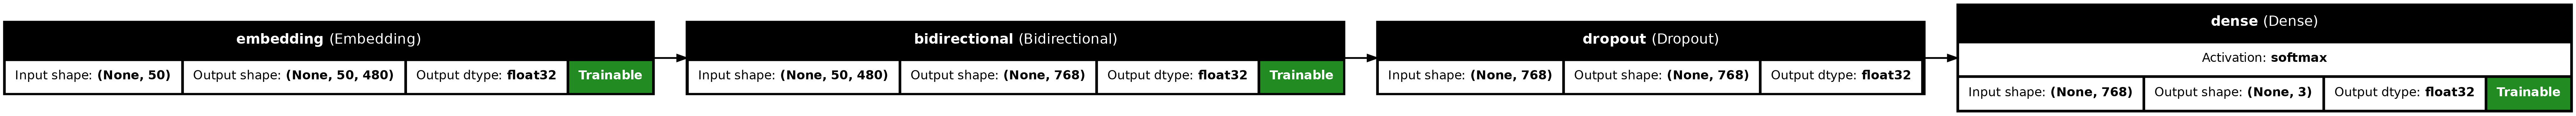

In [17]:
tf.keras.utils.plot_model(best_model, show_shapes=True, show_dtype=True,show_layer_names=True,rankdir='LR',expand_nested=True,dpi=200,show_layer_activations=True,show_trainable=True)

In [25]:
import keras_tuner as kt
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dropout, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K

# Define the custom Attention layer
class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], input_shape[-1]),
                                 initializer="glorot_uniform", trainable=True)
        self.b = self.add_weight(name="att_bias", shape=(input_shape[-1],),
                                 initializer="glorot_uniform", trainable=True)
        super(Attention, self).build(input_shape)

    def call(self, x):
        e = K.tanh(K.dot(x, self.W) + self.b)
        a = K.softmax(e, axis=1)
        output = x * a
        return K.sum(output, axis=1)

# Now, integrate this Attention layer into the model

def build_model(hp):
    model = Sequential()
    
    # Embedding layer with tunable embedding_dim
    model.add(Embedding(vocab_size,
                        hp.Int('embedding_dim', min_value=32, max_value=512, step=32),
                        input_length=max_len))
    
    # First Bidirectional LSTM layer with tunable LSTM units and dropout
    model.add(Bidirectional(LSTM(hp.Int('n_lstm', min_value=32, max_value=512, step=32),
                                 return_sequences=True)))
    model.add(Dropout(hp.Float('drop_lstm', min_value=0.1, max_value=0.5, step=0.1)))
    # Add Attention layer
    model.add(Attention())
    # Dense output layer
    model.add(Dense(3, activation='softmax'))
    
    # Compile the model with tunable learning rate
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Set up the tuner with Hyperband
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=30,
    factor=3,
    directory='my_dir',
    project_name='Hyperparameter_Tuning_Model_BiLSTM_Attention'
)

# Run the hyperparameter search
tuner.search(training_padded, 
             y_train, 
             epochs=30, 
             validation_data=(testing_padded, y_test), 
             callbacks=[early_stop], 
             verbose=1)

# Get the best model and hyperparameters
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]

print("Best Hyperparameters:")
print(best_hyperparameters.values)
best_model.summary()

Trial 90 Complete [00h 00m 25s]
val_accuracy: 0.7697368264198303

Best val_accuracy So Far: 0.8026315569877625
Total elapsed time: 00h 18m 13s
Best Hyperparameters:
{'embedding_dim': 512, 'n_lstm': 320, 'drop_lstm': 0.2, 'tuner/epochs': 10, 'tuner/initial_epoch': 4, 'tuner/bracket': 3, 'tuner/round': 2, 'tuner/trial_id': '0036'}


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 50, 512)        │       256,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 50, 640)        │     2,132,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50, 640)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention (Attention)           │ (None, 640)            │       410,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │         1,923 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,800,643 (10.68 MB)

 Trainable params: 2,800,643 (10.68 MB)

 Non-trainable params: 0 (0.00 B)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.81      0.93      0.87        88
     Class 1       0.00      0.00      0.00        11
     Class 2       0.78      0.75      0.77        53

    accuracy                           0.80       152
   macro avg       0.53      0.56      0.55       152
weighted avg       0.74      0.80      0.77       152



/home/anugerahsurya/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/anugerahsurya/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/anugerahsurya/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


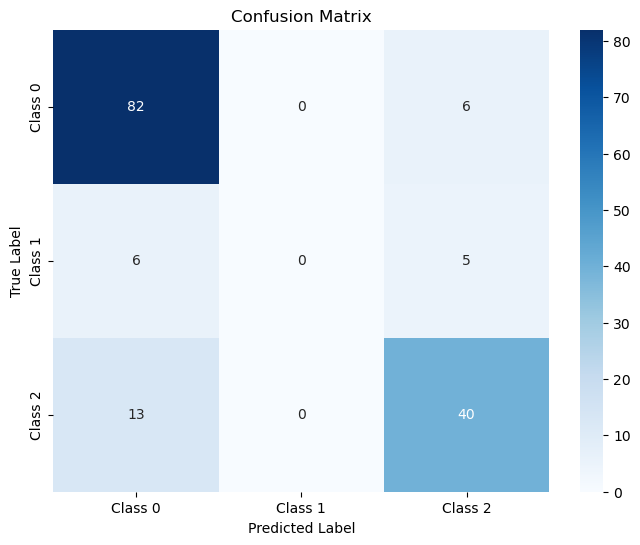

In [27]:
from sklearn.metrics import classification_report, confusion_matrix
# Evaluate the model on the test data
y_pred = np.argmax(best_model.predict(testing_padded), axis=-1)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1', 'Class 2']))

# Plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1', 'Class 2'], yticklabels=['Class 0', 'Class 1', 'Class 2'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Function to predict and classify new input
def predict_new_text(text):
    # Preprocess the text (tokenize, pad, etc.)
    sequences = tokenizer.texts_to_sequences([text])
    padded_sequence = pad_sequences(sequences, maxlen=max_len, padding='post')
    
    # Predict the class
    prediction = best_model.predict(padded_sequence)
    predicted_class = np.argmax(prediction, axis=-1)[0]
    
    # Print the predicted class
    class_labels = ['Negatif', 'Netral', 'Positif']
    print(f"Predicted class: {class_labels[predicted_class]}")

In [29]:
# Example of taking user input and predicting
user_input = input("Enter a sentence to classify: ")
predict_new_text(user_input)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Predicted class: Negatif
